# Long Run Portfolio Choice

This notebook summarizes how the distribution of returns is affected by the investment horizon.

## Load Packages and Extra Functions

In [1]:
using Printf, Distributions

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Long-Run Returns as a Sum of Short-Run Returns

Let $R_{t}$ be a one-period net return. 
The $q$-period return $Z_{q}$ is

$
Z_{q}    =(R_{1}+1)(R_{2}+1)\ldots(R_{q}+1)-1
$

This is sometimes approximated by 

$
Z_{q}   \approx R_{1}+R_{2}+\ldots+R_{q}. 
$

However, log returns $r=\ln (1+R)$ are better suited for multi-period analysis since there is no approximation error in

$z_{q}=r_{1}+r_{2}+\ldots+r_{q}$

In [3]:
R_A = [5,-5,5]/100               #net returns portfolio A in three periods
R_B = [20,-35,25]/100

r_A = log.(1.0.+R_A)             #log returns
r_B = log.(1.0.+R_B)

Price_A = [1;cumprod(1.0.+R_A)]     #price of portfolio A, assuming price in t=0 is 1.0
Price_B = [1;cumprod(1.0.+R_B)]

TotRet_A = Price_A[end]/Price_A[1] - 1    #total return between t=0 and t=3
TotRet_B = Price_B[end]/Price_B[1] - 1

printblue("Prices:")
printmat([Price_A Price_B],colNames=["asset A","asset B"],rowNames=string.(0:3),cell00="period")

printblue("Different types of returns, in %")
xut = [TotRet_A TotRet_B;mean([R_A R_B],dims=1);mean([r_A r_B],dims=1)]
rowNames = ["Total net returns","Average net returns","Average log returns"]
printmat(xut*100;colNames=["asset A","asset B"],rowNames)

Prices:
period   asset A   asset B
0          1.000     1.000
1          1.050     1.200
2          0.997     0.780
3          1.047     0.975

Different types of returns, in %
                      asset A   asset B
Total net returns       4.737    -2.500
Average net returns     1.667     3.333
Average log returns     1.543    -0.844



# Distribution of Long-Run Returns in the iid Case

If the excess log return over one period $r^e$ is iid N$(\mu,\sigma^2)$, then excess log return over $q$ periods is $z^e_q$ is N$(q\mu,q\sigma^2)$.


### A Remark on the Code

The Distributions.jl package defines a normal distribution by `Normal(μ,σ)`, that is, using the standard deviation (not the variance) as the 2nd argument. For horizon `q` we thus use `Normal(q*μ,sqrt(q)*σ)`.

## Pdfs of Long-Run Returns (for Different Horizons)

In [4]:
zᵉ = range(-50,100,length=101)
μᵉ = 0.06*100                                   #average excess return of annual data 
σ  = 0.19*100                                   #std of annual data

pdf_zᵉ1y  = pdf.(Normal(μᵉ,σ),zᵉ)               #pdf of 1-year returns
pdf_zᵉ10y = pdf.(Normal(10*μᵉ,sqrt(10)*σ),zᵉ);  #pdf of 10-year returns

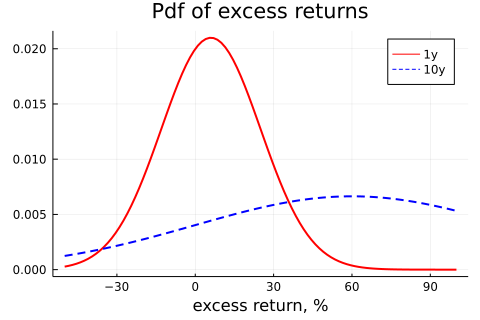

In [5]:
p1 = plot( zᵉ,[pdf_zᵉ1y pdf_zᵉ10y],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           linewidth = 2,
           label = ["1y" "10y"],
           title = "Pdf of excess returns",
           xlabel = "excess return, %" )
display(p1)

##    Prob(zᵉ < 0) for Different Horizons

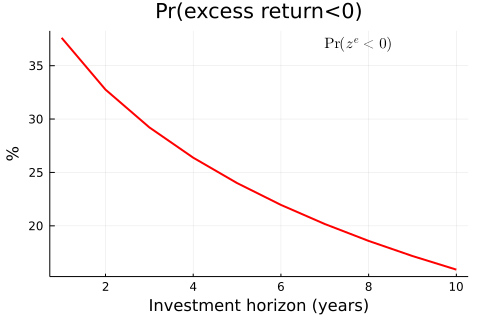

In [6]:
T = 10
ProbNegReturn = fill(NaN,T)
for q = 1:T
    ProbNegReturn[q] = cdf(Normal(q*μᵉ,sqrt(q)*σ),0)  #Pr(z<=0) for different horizons
end

txt = L"\mathrm{Pr}(z^e<0)"
p1 = plot( 1:T,ProbNegReturn*100,
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Pr(excess return<0)",
           xlabel = "Investment horizon (years)",
           ylabel = "%",
           annotation = (7,37,text(txt,10,:left)) )
display(p1)

## E(zᵉ|zᵉ < 0) for Different Horizons

The `Distributions.jl` package has methods fot trunctated distributions. We calculate E$z^e|z^e<0$ for horizon $q$ by using
```
mean(TruncatedNormal(q*μᵉ,sqrt(q)*σ,-Inf,0))
```

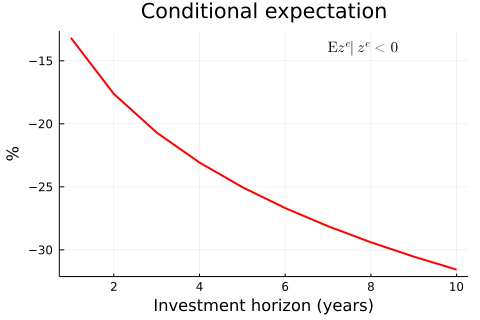

In [7]:
CondER = fill(NaN,T)
for q = 1:T
    CondER[q] = mean(TruncatedNormal(q*μᵉ,sqrt(q)*σ,-Inf,0))
end

txt = L"\mathrm{E}z^e|z^e<0"
p1 = plot( 1:T,CondER,
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Conditional expectation",
           xlabel = "Investment horizon (years)",
           ylabel = "%",
           annotation = (7,-14,text(txt,10,:left)) )
display(p1)